In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data(2, 13, 0)

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=8,
         n_hidden_2=0,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.tanh
num_epochs = 20
batch_size = 5
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001 - Cost:21.868058227
Epoch:0002 - Cost:20.513934150
Epoch:0003 - Cost:18.262609497
Epoch:0004 - Cost:17.487285719
Epoch:0005 - Cost:17.325108183
Epoch:0006 - Cost:16.090945785
Epoch:0007 - Cost:16.033347723
Epoch:0008 - Cost:14.290757029
Epoch:0009 - Cost:14.937185753
Epoch:0010 - Cost:13.963837586
Epoch:0011 - Cost:14.671362291
Epoch:0012 - Cost:13.671589236
Epoch:0013 - Cost:14.376235271
Epoch:0014 - Cost:13.307567244
Epoch:0015 - Cost:12.794855223
Epoch:0016 - Cost:13.395027213
Epoch:0017 - Cost:11.545756727
Epoch:0018 - Cost:12.505062584
Epoch:0019 - Cost:11.361872774
Epoch:0020 - Cost:11.557234516
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    samples = test_data.next_batch(1)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 0.82948142  0.60118691  2.88712045  0.99569425 -0.26352316 -1.04880885
   1.58113883 -0.48507125 -1.32959555  0.82220467 -0.26424317  0.4513875
  -0.57240795 -0.48010721 -0.97777561 -0.32444284 -0.32444284 -0.48507125
   1.78885438 -0.32444284 -0.40824829 -0.55901699]]
[[ 1.3103484   1.1248044   0.5370164   1.161376   -1.2543132  -0.8978627
   0.17748505  0.6844152  -0.983576   -0.03582516 -0.0412423   0.9024854
  -0.5030068  -0.17119285 -0.8800178  -1.3182905  -1.1575441  -0.08208972
   0.8524382  -0.75909793  0.86116445 -0.38823378]
 [ 0.6373316   0.4655701   0.6930705   0.54039186 -0.6866295  -0.7908762
   0.49174854  0.15161589 -0.8568039  -0.19013828 -0.1134437   0.4284894
  -0.518021   -0.24547091 -0.6452528  -0.74886227 -0.67170805  0.11513501
   0.8937334  -0.6744374   0.24408884 -0.43873364]
 [ 1.3676699   1.2308179   0.27113014  1.2179496  -0.9917566  -0.83611435
  -0.02556276  0.927778   -0.90460116  0.25000

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    
    batch_size = 1
    avg_cost = 0.
    avg_distance_norm = 0
    avg_distance_unnorm = 0
    for i in range(num_samples):
        batch = test_data.next_batch(1)

        x_reconstructed = network.encode_and_decode(samples)
        cost = network.calculate_loss(batch)
        
        #print(batch[0])
        _, unstandardized_batch = test_data.decode_processed_tensor(batch[0])
        _, unstandardized_x = test_data.decode_processed_tensor(x_reconstructed[0])
        distance_unnorm = (sess.run(tf.reduce_sum(tf.abs(unstandardized_batch - unstandardized_x))))
        
        distance_norm = (sess.run(tf.reduce_sum(tf.abs(batch[0] - x_reconstructed[0]))))
        #print(cost)

        #compute average loss/cost
        avg_cost += cost / num_samples
        avg_distance_unnorm += distance_unnorm / num_samples
        avg_distance_norm += distance_norm / num_samples
    
    print("Average cost = " + "{:.9f}".format(avg_cost))
    print("Average unnormalized distance = " + "{:.9f}".format(avg_distance_unnorm))
    print("Average normalized distance = " + "{:.9f}".format(avg_distance_norm))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Average cost = 12.472173623
Average unnormalized distance = 577.405178023
Average normalized distance = 21.409152753


In [23]:
tf.reset_default_graph()

with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    max_value = np.amax(test_data.standardized_max_values) *1.
    min_value = np.amin(test_data.standardized_min_values) *1.
    print("max = %f, min = %f" %(max_value, min_value))
    
    
    max_value_arr = test_data.standardized_max_values
    min_value_arr = test_data.standardized_min_values

    avg_cost = 0.
    for i in range(num_samples):
        sample = np.random.uniform(low=min_value, high=max_value, size=(1,network_architecture["n_input"]))
        sample = np.random.uniform(low=min_value_arr, high=max_value_arr, size=(1,network_architecture["n_input"]))
        cost = network.calculate_loss(sample)
        avg_cost += cost / num_samples
    print("Average cost = " + "{:.9f}".format(avg_cost))
    


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
max = 3.126407, min = -1.686422
Average cost = 44.167407899


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


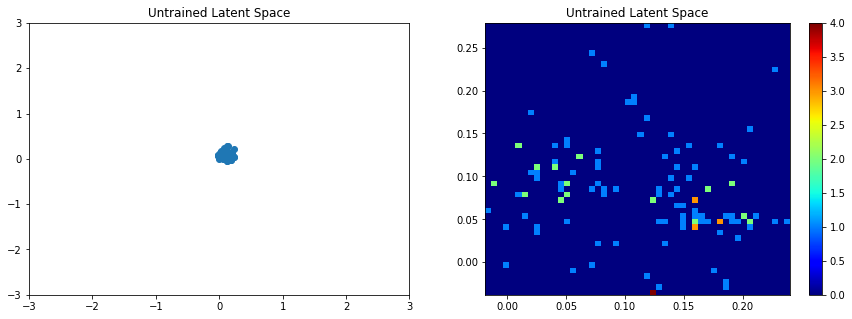

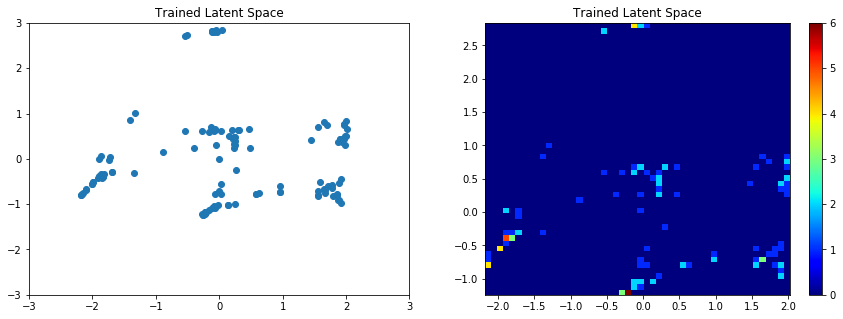

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [10]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        
        
        
        cost = network.calculate_loss(batch)
        
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[-3.94385834 -2.68272743]]
[[-3.62828752  4.63353835]]
[[ 0.63139205 -2.83601936]]
[[-4.08392756 -4.68194777]]
damages_first = ['24.28943129817027', '58.03770272047838', '44.644032777783', '74.14417050370577']
damages_last = ['13.542529026371149', '40.91274700077175', '27.127461841197167', '58.87449142991042']
dmg_distances_first = ['13.373698665818909', '24.717370109871766', '24.224551587511108', '14.171939307271867']
dmg_distances_last = ['32.613580660959016', '81.56594631047273', '59.34976554607947', '106.41245123397785']
drag = ['0.002711917409874637', '0.00213975850017422', '0.0026486406004540414', '0.002399351436648058']
firemode_Automatic = ['0.7878075627723977', '-0.0161353300012414', '0.04493297303473626', '-0.005229904138681241']
firemode_Semi-Automatic = ['0.28589175717759496', '0.6291486735874994', '0.7224447065941089', '0.30055662417174017']
hiprecoildec = ['7.785047306791787', '3.1712474637300354', '3.77743